## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

# Tensorflow libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#matplotlib style
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False

# project package
from src.plot_functions import plot_acc_loss
from src.training_functions import train
from src.init_data import create_train_val_data_from_directory

In [2]:
data_dir = "/home/titou/Documents/git/flower_image_class/data/flower_photos/"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'{image_count} images in the dataset')

3670 images in the dataset


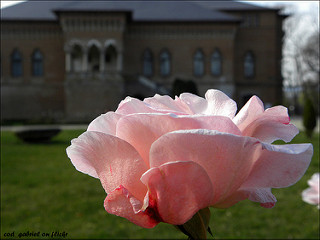

In [3]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[34]))

## Create the Dataset

In [4]:
img_height = 180
img_width = 180
batch_size = 32

train_ds, validation_ds = create_train_val_data_from_directory(data_dir)

class_names = train_ds.class_names
print(class_names)



Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2022-07-21 12:25:52.437009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 12:25:52.442450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 12:25:52.442684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 12:25:52.443355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Visualize dataset

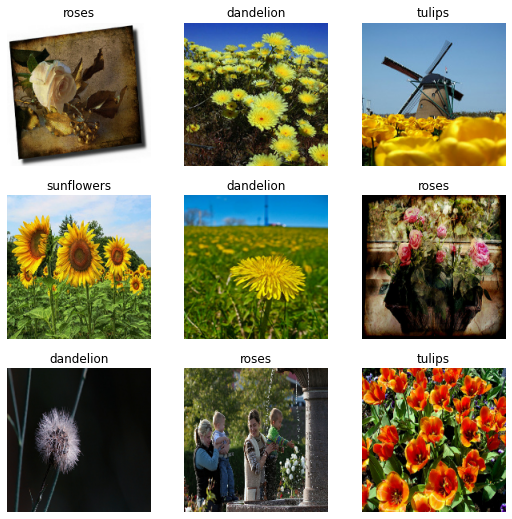

In [5]:
def plot_9_images(image_list, label_list):
    plt.figure(figsize=(9, 9))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_list[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



for i, l in train_ds.take(1):
    images = i
    labels = l

plot_9_images(images, labels)

## Create model

In [6]:
#Preformance improvement for the IO part of the training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
def create_model(num_classes):

    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])


    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model


## Train Model

In [8]:
# Create and train the model

num_classes = len(class_names)
model = create_model(num_classes)
epochs = 10
history = train(model, epochs=epochs, train_data=train_ds, val_data=validation_ds)

Epoch 1/10


2022-07-21 12:26:02.816131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-21 12:26:03.366588: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 12:26:03.367003: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 12:26:03.367030: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-21 12:26:03.367444: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 12:26:03.367486: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-21 12:26:03.905145: I tensorflow/stream_executor/cuda/c

92/92 [==============================] - 5s 24ms/step - loss: 1.2364 - accuracy: 0.4901 - val_loss: 1.0652 - val_accuracy: 0.5749
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9730 - accuracy: 0.6172 - val_loss: 0.9676 - val_accuracy: 0.6253
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8140 - accuracy: 0.6829 - val_loss: 0.8752 - val_accuracy: 0.6594
Epoch 4/10
92/92 [==============================] - 2s 22ms/step - loss: 0.6156 - accuracy: 0.7772 - val_loss: 0.9836 - val_accuracy: 0.6267
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4150 - accuracy: 0.8559 - val_loss: 1.0746 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2318 - accuracy: 0.9155 - val_loss: 1.0961 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1417 - accuracy: 0.9547 - val_loss: 1.2893 - val_accuracy: 0.6594
Epoch 8/10
92/92 [======

## Results

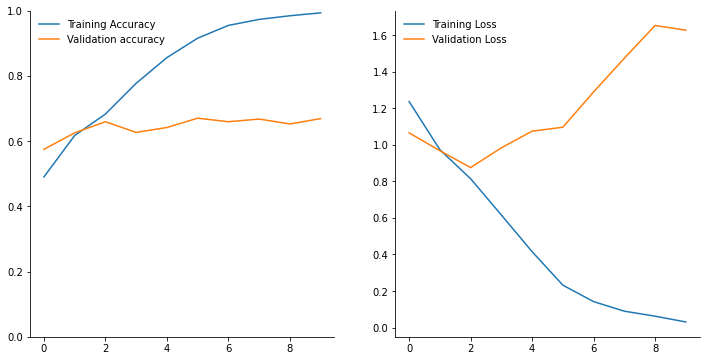

In [9]:
plot_acc_loss(history, epochs)

## Data Augmentation

In [10]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
])


In [11]:
def plot_9_augment_image(image_list):
    plt.figure(figsize=(9,9))
    for i in range(9):
        aug_image = data_augmentation(image_list)
        plt.subplot(3, 3, i+1)
        plt.imshow(aug_image[0].numpy().astype('uint8'))
        plt.axis('off')
    

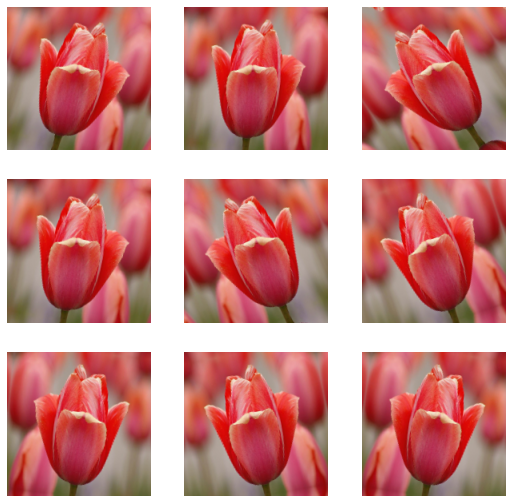

In [12]:
# visualize data augmented images

for i, _ in train_ds.take(1):
    image_list = i

plot_9_augment_image(image_list)


## Dropout and Data augmentation in training

In [13]:
def create_better_model(num_classes):

    model = Sequential([

        # Data augmentation
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),

        # Convolutional network
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])


    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model


In [14]:
better_model = create_better_model(num_classes)
epochs_better = 50
better_history = train(better_model, epochs_better, train_ds, validation_ds)


Epoch 1/50
92/92 [==============================] - 4s 38ms/step - loss: 1.3600 - accuracy: 0.4022 - val_loss: 1.1345 - val_accuracy: 0.5191
Epoch 2/50
92/92 [==============================] - 3s 37ms/step - loss: 1.0780 - accuracy: 0.5651 - val_loss: 0.9759 - val_accuracy: 0.6063
Epoch 3/50
92/92 [==============================] - 3s 36ms/step - loss: 0.9960 - accuracy: 0.6114 - val_loss: 0.9311 - val_accuracy: 0.6349
Epoch 4/50
92/92 [==============================] - 3s 37ms/step - loss: 0.9134 - accuracy: 0.6376 - val_loss: 0.9456 - val_accuracy: 0.6226
Epoch 5/50
92/92 [==============================] - 3s 36ms/step - loss: 0.8424 - accuracy: 0.6730 - val_loss: 0.8225 - val_accuracy: 0.6676
Epoch 6/50
92/92 [==============================] - 3s 37ms/step - loss: 0.7820 - accuracy: 0.6894 - val_loss: 0.7478 - val_accuracy: 0.7071
Epoch 7/50
92/92 [==============================] - 3s 36ms/step - loss: 0.7425 - accuracy: 0.7173 - val_loss: 0.7785 - val_accuracy: 0.6962
Epoch 8/50
92

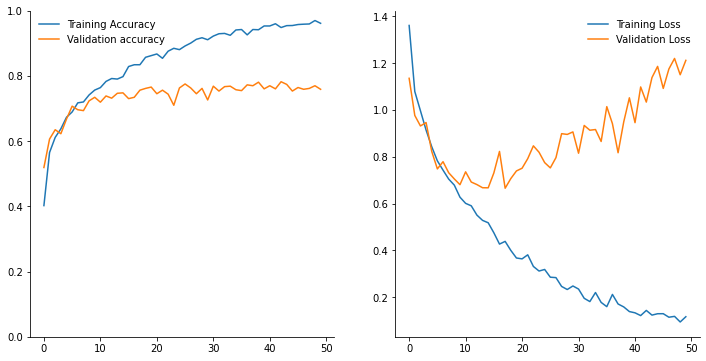

In [15]:
plot_acc_loss(better_history, epochs_better)